# Imports

In [46]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import scale, normalize, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score

from umap import UMAP
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Globals

In [2]:
DATA_BASE_PATH = "/mnt/cluster_vsbud-dl1-005/hackathon"
META_PATH = "/mnt/cluster_vsbud-dl1-005/hackathon_meta/metadata.csv"

In [52]:
df_meta = pd.read_csv(META_PATH, sep=',', index_col=0)

default_filter = df_meta['DischargeTo_Agg'] != 'exitus'
df_meta = df_meta[default_filter]

len(df_meta)

33522

In [12]:
df_meta['DgCode'].str.extract(r"([A-Z])").value_counts(dropna=False)

I      25451
R       5586
J        546
Z        513
M        335
K        185
T        172
N        122
F        118
A        109
E        109
D         93
U         47
G         37
H         23
C         17
NaN       16
S         15
L         12
Q          9
B          5
O          3
dtype: int64

In [4]:
df_meta.describe().T

,count,mean,std,min,25%,50%,75%,max
VentricularRate,33523.0,84.900964,26.488829,22.0,67.0,79.0,97.0,246.0
AtrialRate,33523.0,97.613101,62.308859,0.0,66.0,79.0,101.0,681.0
PRInterval,22292.0,176.448861,439.816281,40.0,146.0,166.0,192.0,65532.0
QRSDuration,33523.0,104.134594,27.154937,4.0,86.0,96.0,112.0,414.0
QTInterval,33523.0,394.876354,60.415846,82.0,358.0,394.0,428.0,776.0
QTCorrected,33523.0,455.770217,49.309208,0.0,425.0,449.0,479.0,917.0
PAxis,22020.0,52.970481,33.921842,-89.0,37.0,54.0,69.0,270.0
RAxis,33523.0,17.014975,56.985846,-89.0,-22.0,12.0,49.0,270.0
TAxis,33523.0,52.634579,64.585517,-89.0,14.0,43.0,80.0,270.0
QRSCount,33523.0,13.952510,4.374476,4.0,11.0,13.0,16.0,40.0


In [ ]:
features = [
    'VentricularRate',
    'AtrialRate',
    'QRSDuration',
    'QTInterval',
    'QTCorrected',
    'RAxis',
    'TAxis',
    'QRSCount',
    'QOnset',
    'QOffset',
    'TOffset',
]

# UMAP explore

In [20]:
label_encoder = LabelEncoder()

pca = PCA(0.95)
umap = UMAP(n_components=2, n_neighbors=1000, n_jobs=60)

y = label_encoder.fit_transform(df_meta['DischargeTo_Agg'].values)
x = df_meta[features].values
x = scale(x)
x_pca = pca.fit_transform(x)

x_umap = umap.fit_transform(x_pca)

In [22]:
label_encoder.classes_

array(['cardiology clinic', 'exitus', 'other', 'outpatient'], dtype=object)

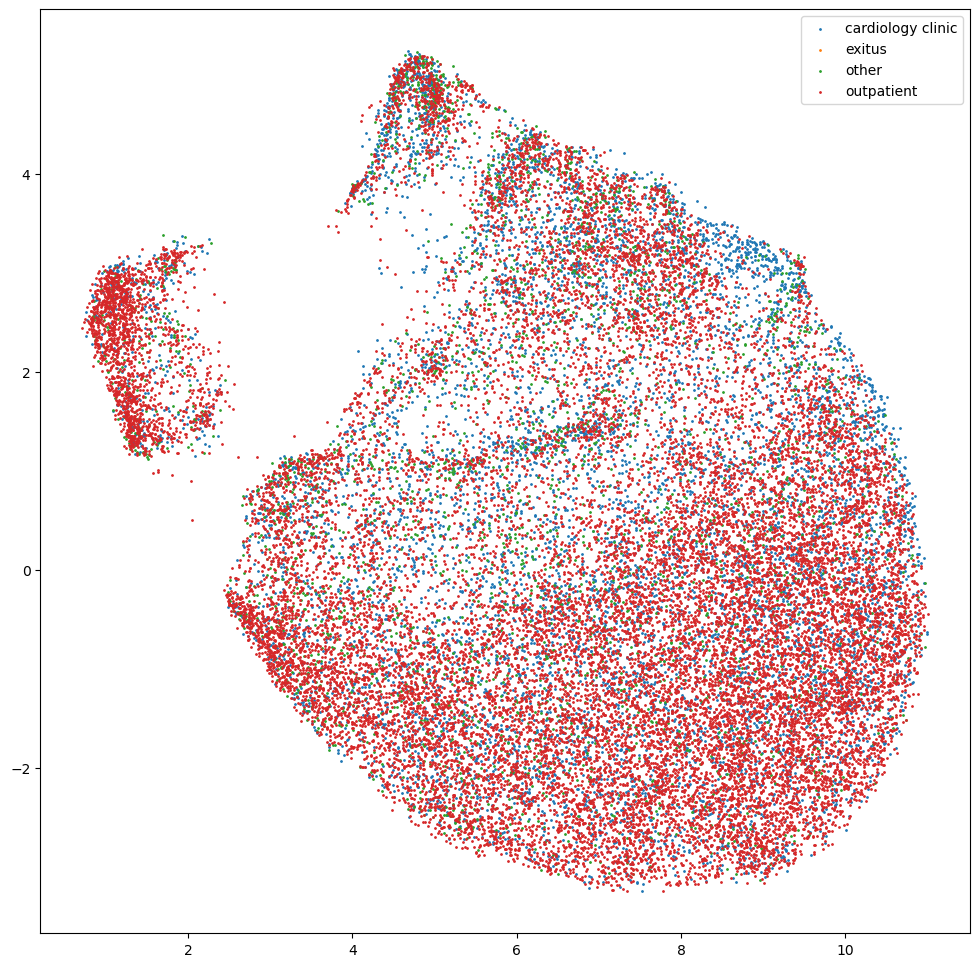

In [27]:
plt.figure(figsize=(12,12))
for label in np.unique(y):
    label_filter = y == label
    plt.scatter(x_umap[label_filter, 0], x_umap[label_filter, 1],  s=1, label=label_encoder.classes_[label])
plt.legend()

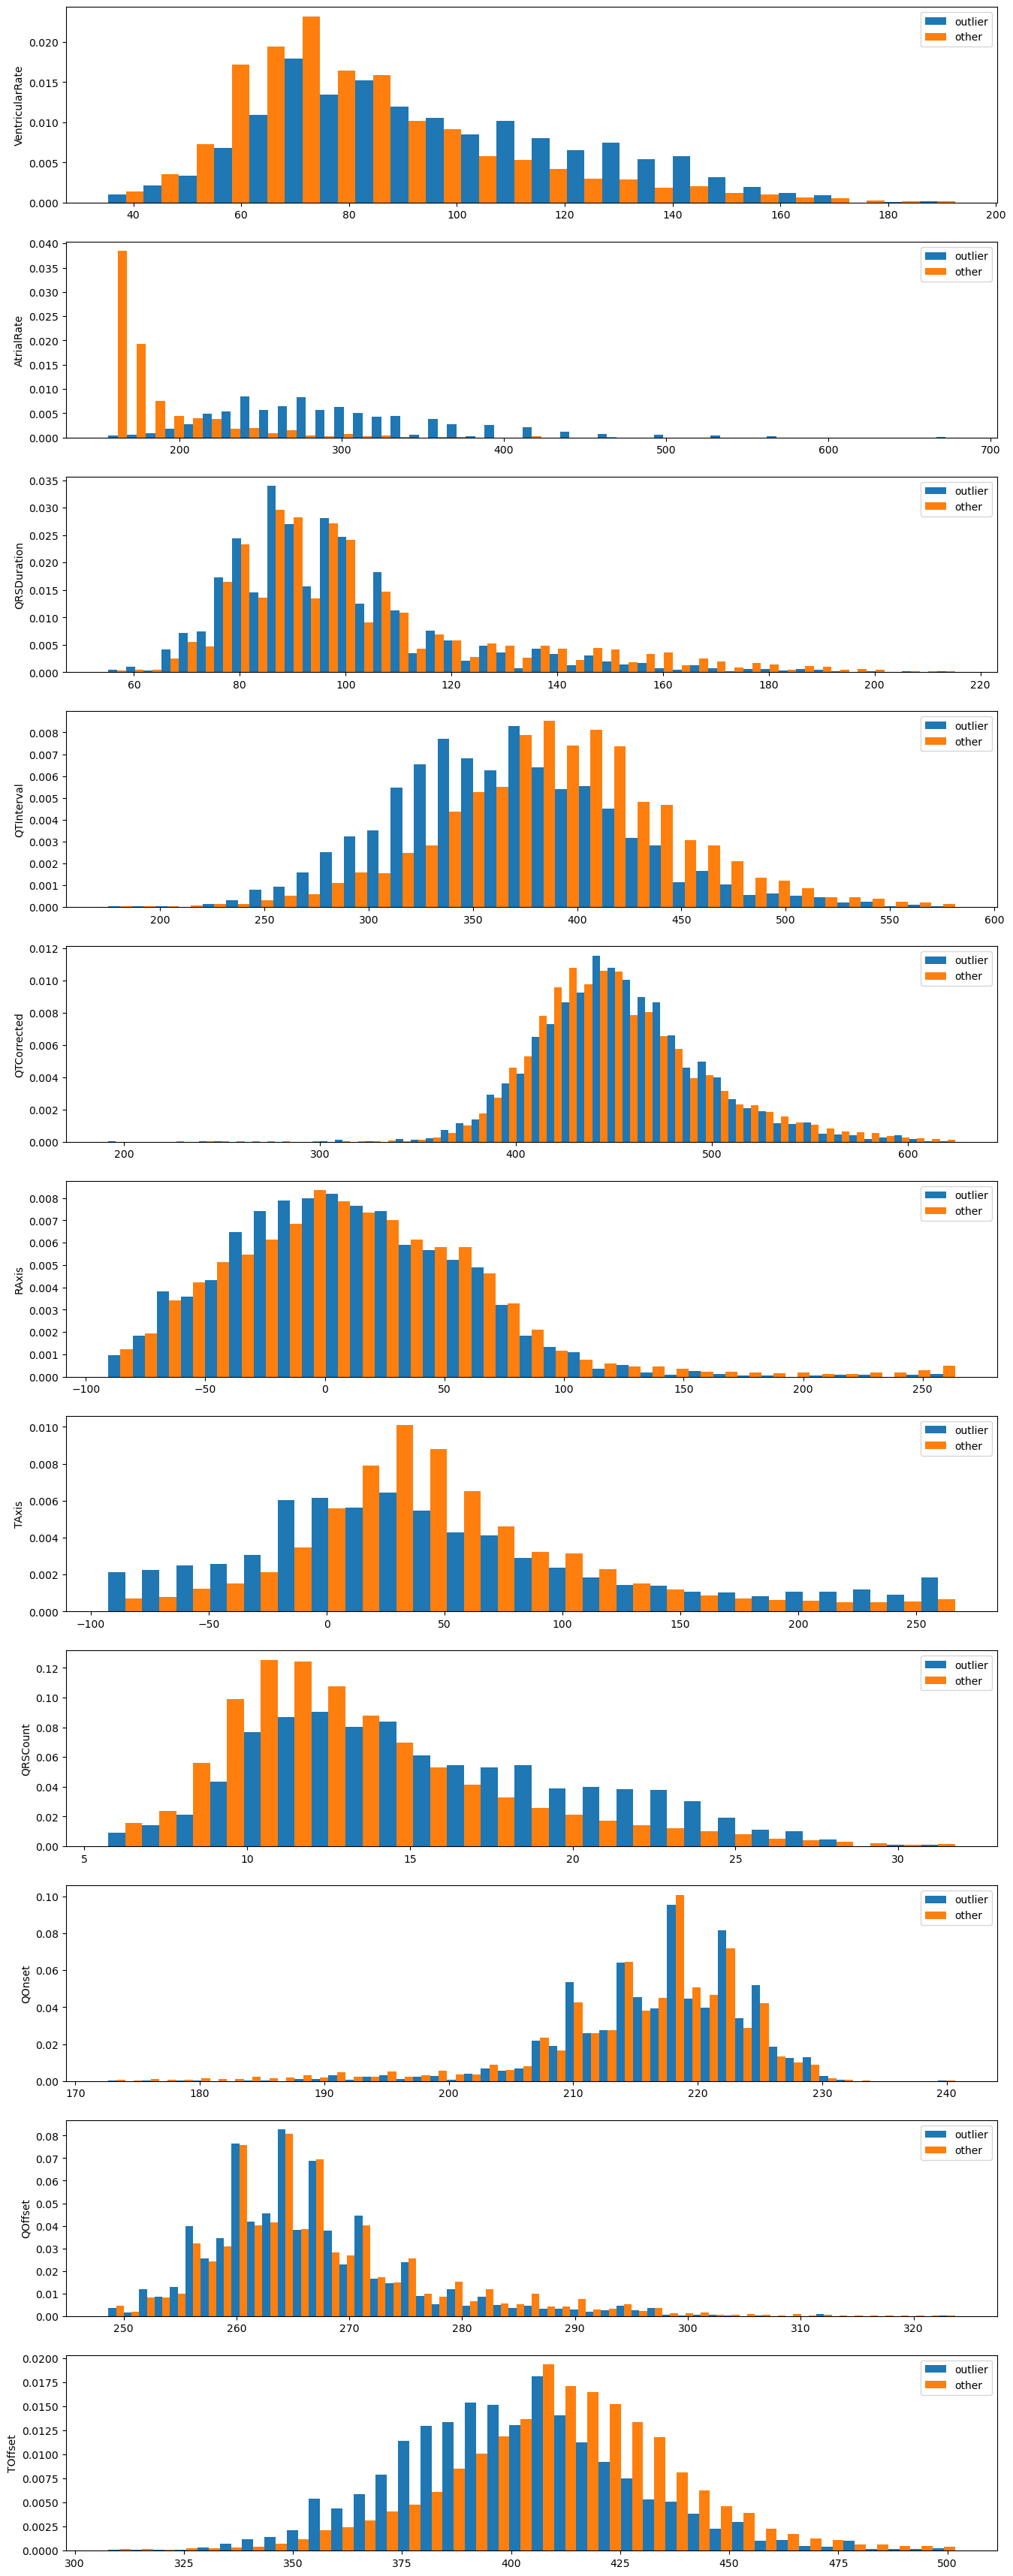

In [39]:
x_filter = (
    (x_umap[:, 0] < 2.5)
    & (x_umap[:, 1] > 1)
    & (x_umap[:, 1] < 3.5)
)

nrow = len(features)
fig, axs = plt.subplots(nrow, 1, figsize=(16,4*nrow))
for i, feature in enumerate(features):
    
    ax = axs[i]
    
    hist, bin_edges = np.histogram(df_meta.loc[x_filter, feature].values, bins='auto', density=True)
    width = np.diff(bin_edges)
    ax.bar(bin_edges[:-1], hist, width=width/2, label="outlier")
    
    hist, bin_edges = np.histogram(df_meta.loc[~x_filter, feature].values, bins=bin_edges, density=True)
    width = np.diff(bin_edges)
    ax.bar(bin_edges[:-1]+width/2, hist, width=width/2, label="other")
    
    ax.set_ylabel(feature)
    ax.legend()
    
plt.show()

In [ ]:
from ECGXMLReader.ECGXMLReader import ECGXMLReader

nrow = 100
fig, axs = plt.subplots(nrow, 4, figsize=(20, nrow*4))

for i in range(nrow):
    
    fname = df_meta[x_filter]['file'].values[i]
    ecg = ECGXMLReader(f'{DATA_BASE_PATH}/{fname}', augmentLeads=True)
    patient = ecg.PatientDemographics['PatientID']
    label = df_meta[x_filter]['DischargeTo_Agg'].values[i]
    
    ax = axs[i, 0]
    ax.plot(ecg.LeadVoltages[0]['II'])
    ax.set_title(f"{patient} - outlier - {label}", fontsize=16)
    
    ax = axs[i, 1]
    ax.plot(ecg.LeadVoltages[1]['II'])
    ax.set_title(f"{patient} - outlier - {label}", fontsize=16)
    
    fname = df_meta[~x_filter]['file'].values[i]
    ecg = ECGXMLReader(f'{DATA_BASE_PATH}/{fname}', augmentLeads=True)
    patient = ecg.PatientDemographics['PatientID']
    label = df_meta[~x_filter]['DischargeTo_Agg'].values[i]
    
    ax = axs[i, 2]
    ax.plot(ecg.LeadVoltages[0]['II'])
    ax.set_title(f"{patient} - inlier - {label}", fontsize=16)
    
    ax = axs[i, 3]
    ax.plot(ecg.LeadVoltages[1]['II'])
    ax.set_title(f"{patient} - inlier - {label}", fontsize=16)
    
fig.tight_layout()
plt.show()

# SVM

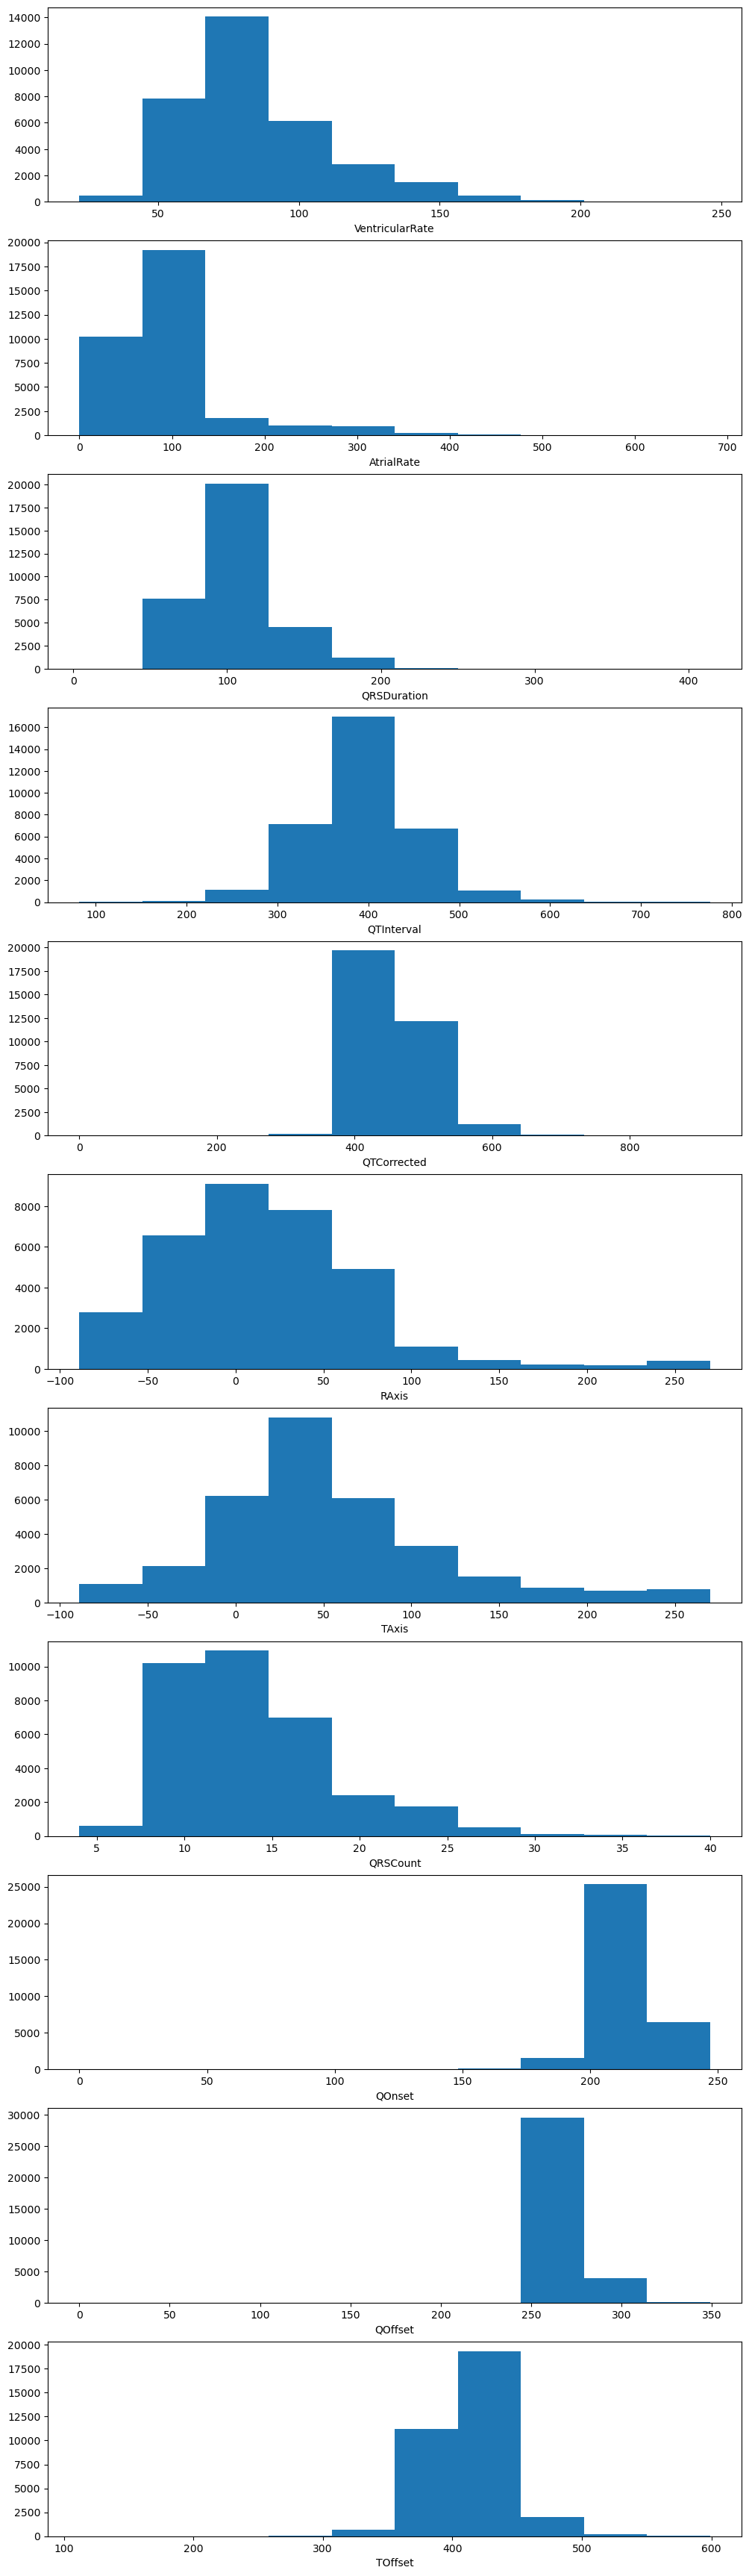

In [69]:
x = df_meta[features].values
fig, axs = plt.subplots(len(features), 1, figsize=(12,4*len(features)))
for i, ax in enumerate(axs):
    ax.hist(x[:, i])
    ax.set_xlabel(features[i])
plt.show()

In [60]:
def get_balanced_sample_weights(y):
    return normalize(1/np.bincount(y).reshape(1, -1))[0][y]

label_encoder = LabelEncoder()
features = [
    'VentricularRate',
    'AtrialRate',
    'QRSDuration',
    'QTInterval',
    'QTCorrected',
    'RAxis',
    'TAxis',
    'QRSCount',
    'QOnset',
    'QOffset',
    'TOffset',
    'age'
]

pca = PCA(0.95)
svm = SVC()

y = label_encoder.fit_transform(df_meta['DischargeTo_Agg'].values)
x = df_meta[features].values
x = scale(x)
x_pca = pca.fit_transform(x)

scores = {
    'acc': [], 'prec': [], 'rec': [], 'fpr':[], 'fnr':[], 'tpr':[], 'tnr':[] 
}
for train_idx, test_idx in tqdm(ShuffleSplit(n_splits=10, random_state=42).split(x)):
    svm.fit(x_pca[train_idx], y[train_idx], 
            sample_weight=get_balanced_sample_weights(y[train_idx]))
    
    y_pred = svm.predict(x_pca[test_idx])
    y_true = y[test_idx]
    
    scores['tpr'].append(((y_true == 1) & (y_pred == 1)).sum() / (y_true == 1).sum())
    scores['fpr'].append(((y_true == 1) & (y_pred == 0)).sum() / (y_true == 1).sum())
    scores['tnr'].append(((y_true == 0) & (y_pred == 0)).sum() / (y_true == 0).sum())
    scores['fnr'].append(((y_true == 0) & (y_pred == 1)).sum() / (y_true == 0).sum())
    scores['acc'].append(accuracy_score(y_true, y_pred))
    scores['prec'].append(precision_score(y_true, y_pred, average='micro'))
    scores['rec'].append(recall_score(y_true, y_pred, average='micro'))

0it [00:00, ?it/s]

array([[0.32505303, 0.9370028 , 0.1279308 ]])

In [62]:
for key, score in scores.items():
    print(key, np.mean(score))

acc 0.6733074858335819
prec 0.6733074858335819
rec 0.6733074858335819
fpr 0.07777205984333496
fnr 0.0005934415874057433
tpr 0.005817330534298559
tnr 0.11472435295357217


In [65]:
pd.value_counts(y_true)

2    2174
0     883
1     296
dtype: int64

In [64]:
pd.value_counts(y_pred)

2    3179
0     173
1       1
dtype: int64